## 1.1.1 Prepatory work and modelling

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

### Simulation of syntetic dataset from a bivariate GMM

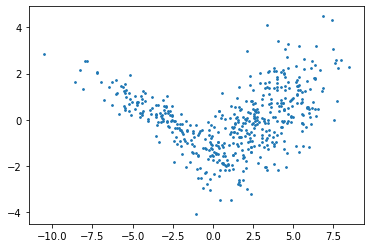

In [2]:
def sample_biv_normal(n):
    m1 = np.array([-3, 0])
    m2 = np.array([3, 0])
    s1 = np.array([[5, -2], [-2, 1]])
    s2 = np.array([[5, 2], [2,2]])
    p1 = 0.3
    p2 = 0.7
    n1 = math.floor(n * 0.3)
    n2 = math.floor(n * 0.7)
    
    rng = np.random.default_rng()
    return np.concatenate((rng.multivariate_normal(m1, s1, n1), rng.multivariate_normal(m2, s2, n2)))


samples = sample_biv_normal(500)
plt.scatter(samples[:, 0], samples[:, 1], s = 3)
plt.show()

In the figure below, we show the 2D scatter plot of a set of samples generated using a mixture of two Normal distributions. Although roughly sketched, it is not difficult to see that the distribution of points in the plane could resemble that of a handwriting stroke, for example, one for writing the capital letters `V` or `A` (inverted) of the alphabet.

### Processing the Unistroke dataset

In [3]:
def parse_file(letter, path = "Unistroke", n = 50):
    data = []
    
    for i in range(n):
        sample = []
        filename = f"{path}/{letter}{(i + 1):02d}.txt"
        with open(filename, "r") as f:
            for line in f:
                x = list(map(float, line.split()))
                sample.append(x)
        data.append(sample)
    return np.array(data, dtype = object)

def scatter_plot(data):
    for sample in data:
        s = np.array(sample)
        plt.scatter(s[:,0], s[:,1], s = 1)

Read and plot the data (as points in 2D) for letter `A`.

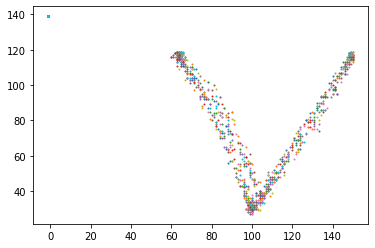

In [4]:
data = parse_file("A")
scatter_plot(data)

#### Filter outliers

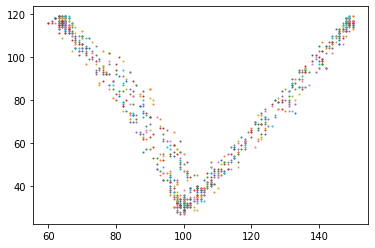

In [5]:
def filter_outliers(predicate, data):
    return list(map(lambda sample: list(filter(predicate, sample)), data))

filtered = filter_outliers(lambda x: x[0] > 50, data)
scatter_plot(filtered)

The figure above shows a scatterplot of the data available for letter `A` once the outliers (or errors from the capture) have been removed. Fairly intuitively, by comparing this plot with the one with generated data, we can see the drawing of letter `A` could probabily be explained as a mixture of two normally distributed sets of data. 

However, for a model like this to be able to represent an actual letter drawing accurately, it would be very convinient be able to identify the direction of the stroke at any given time `t` of the drawing. We can compute this direction of a stroke at time t, as the normalised vector from position `(x[t], y[y])` to position `(x[t+1], y[t+1])`. Note that if two subsequent data points have the same coordinates, the difference between them will be 0. We filter out these difference vectors of length 0 as they do not contain any direction information.

In the following code, we compute and plot these normalized vectors. The plot reassures the computations as the vectors now lay on a unit circle:

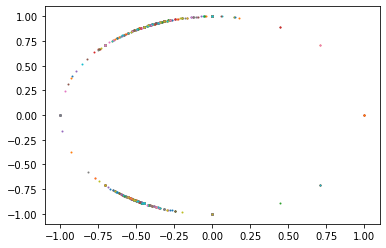

In [6]:
def compute_normalized_directions(data):
    res = []
    for sample in data:
        sample_res = []
        for i in range(1, len(sample)):
            difference = np.array(sample[i]) - np.array(sample[i-1])
            norm = np.linalg.norm(difference)
            if norm > 0: 
                sample_res.append(difference / norm)
        res.append(sample_res)
    return res

directions = compute_normalized_directions(filtered)
scatter_plot(directions)

## Task 1.1.2

### 1. Estimate GMM

In the plot above we can identify two clusters. We thus assume a two-component generative model, more precisely a Gaussian Mixture Model. As the data is two dimensional, we choose a *bivariate* GMM.

As we only care for single direction vectors, there is no point to distinguish between samples. We thus concatenate the direction vectors of all samples in an that we use as training set. We then use `sklearn`'s implementation of the EM-algorithm to fit a GMM and label the training data.

In [7]:
import sklearn.mixture
import itertools

#concatenate directions from all samples into one list
training_data = np.array(list(itertools.chain.from_iterable(directions)))

#Estimate a bivariate GMM with 2 components
nrOfComponents = 3
mixtureModel = sklearn.mixture.GaussianMixture(n_components=nrOfComponents)
# mixtureModel.get_params()
# mixtureModel.fit_predict(training_data)
# mixtureModel.weights_
bivariate_labels = mixtureModel.fit_predict(training_data)

#Parameters of the fitted model
print("Model converged: ", mixtureModel.converged_)
print("Weights of each mixture components: ",  mixtureModel.weights_)
print("Means of each mixture components [mean_x,mean_y]: ", *mixtureModel.means_, sep='\n')
print("Covariance matrix of first mixture component : ", *mixtureModel.covariances_[:][0], sep='\n')
print("Covariance matrix of second mixture component : ", *mixtureModel.covariances_[:][1], sep='\n')

# Uncomment to three gaussian components
# print("Covariance matrix of third mixture component : ", *mixtureModel.covariances_[:][2], sep='\n')

Model converged:  True
Weights of each mixture components:  [0.4704166  0.46079205 0.06879135]
Means of each mixture components [mean_x,mean_y]: 
[-0.30909253  0.91087719]
[-0.44616767 -0.87005211]
[-0.80666277  0.47638256]
Covariance matrix of first mixture component : 
[ 0.06097596 -0.00775862]
[-0.00775862  0.0137906 ]
Covariance matrix of second mixture component : 
[ 0.03880802 -0.00755488]
[-0.00755488  0.00513772]


# 2. Plot GMM and data

To viusalize how the estimation fits the actual data, we plot the estimated probability density function (pdf) and the training data. More precisely, the plot shows level curves (similar to contour lines in topographic maps). each curve corresponding to all points x with the same pdf-value p(x). The curves are labeled by their negative logarithm, i.e. `-ln(p(x))`.

Data points are plotted in blue or red color, depending on their classification by the GMM.

<ipython-input-8-ca6b552f612e>:16: UserWarning: Log scale: values of z <= 0 have been masked
  contours = plt.contour(X, Y, Z, norm=LogNorm(vmin=0.5, vmax=1000.0), levels=np.logspace(0, 4, 10))


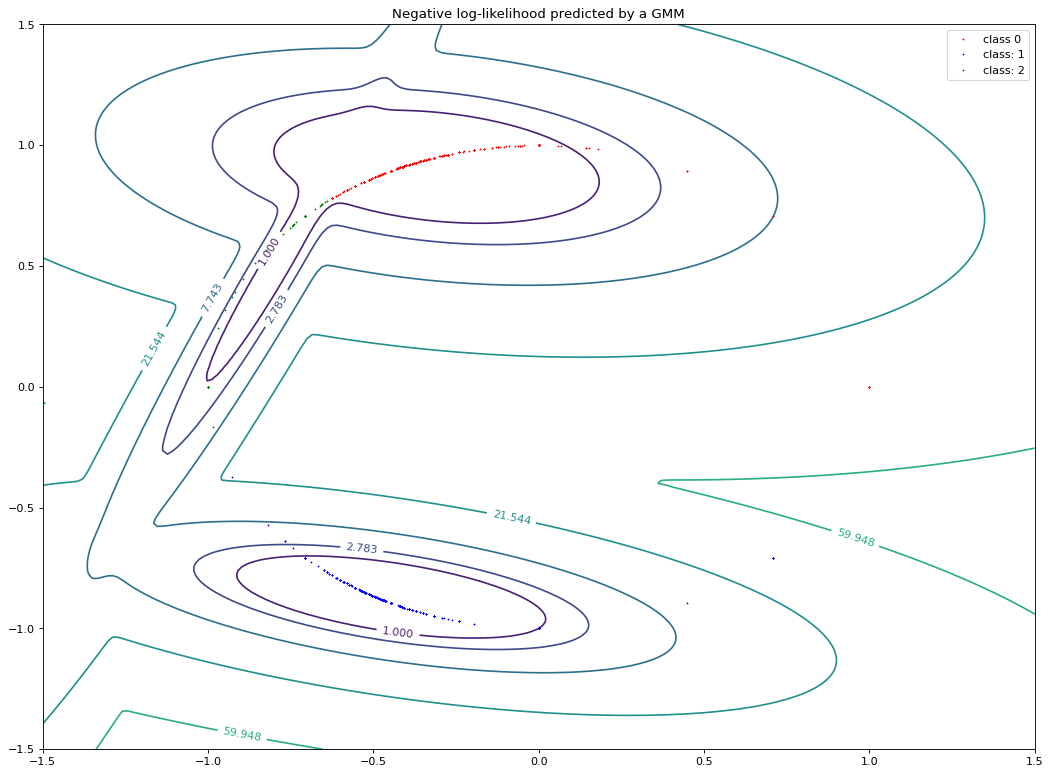

In [8]:
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib.markers
# sample the pdf (negative log liklihood)
x = np.linspace(-1.5, 1.5, 200)
y = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -mixtureModel.score_samples(XX)
Z = Z.reshape(X.shape)


figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
#plot pdf (contours) 
contours = plt.contour(X, Y, Z, norm=LogNorm(vmin=0.5, vmax=1000.0), levels=np.logspace(0, 4, 10))
plt.clabel(contours, inline=1, fontsize=10)

#plot data points
cluster0 = np.array([x for x,l in zip(training_data, bivariate_labels) if l == 0])
cluster1 = np.array([x for x,l in zip(training_data, bivariate_labels) if l == 1])
plt.plot(cluster0[:,0], cluster0[:,1], marker="x", label="class 0", linestyle="", color="red", markersize=1)
plt.plot(cluster1[:,0], cluster1[:,1], marker="x", label="class: 1", linestyle="", color="blue", markersize=1)

# Uncomment to three gaussians components
cluster2 = np.array([x for x,l in zip(training_data, bivariate_labels) if l == 2])
plt.plot(cluster2[:,0], cluster2[:,1], marker="x", label="class: 2", linestyle="", color="green", markersize=1)

plt.title('Negative log-likelihood predicted by a GMM')
plt.legend()
plt.show()

We observe that most points have a probability higher than e^(-1) = 0.36 according to the pdf and that there are few outlieres. However, two dimensional Gaussians  have an ellipsoid form whereas the all data points lie on a cureve (the unit circle). Fitting a circular arc by an ellipsoid naturally results in a less well fitted model.

### 3. Marginal distributions

We now want to study the assumption of a *bivariate* GMM. To this end we consider marginal distributions, i.e. the projection the data to the x-axis and y-axis respectively. We then estimate univariate, Gaussians with two-components for each marginal.


In [ ]:
import scipy.stats

def plot_marginal(data):
    #plot histogram 
    plt.hist(data, 25)

    #estimate GMM with 2 components
    gmm = sklearn.mixture.GaussianMixture(2)
    labels = gmm.fit_predict(data.reshape(-1,1))

    #plot histogram with a separate vertcial axis
    x = np.linspace(-1, 1, 100).reshape(-1, 1)
    ax2 = plt.twinx()
    p = np.exp(gmm.score_samples(x)) #gmm.score_samples gives log probabilites
    ax2.plot(x, p, c='red')
    return labels

x_marginal = training_data[:,0]
y_marginal = training_data[:,1]

univariate_x_labels = plot_marginal(x_marginal)
plt.title("Figure 3.1: x marginal")
plt.show()

univariate_y_labels = plot_marginal(y_marginal)
plt.title("Figure 3.2: y marginal")
plt.show()


The blue bars are the marginal histograms of the input data, for x and y going from -1 to 1 each. The red curve is the fitted univariate GMM for each marginal.

We now consider the marginals of the clusters identified by the bivariate model. For each cluster, we plot the y and x marginal.


In [ ]:
plot_marginal(cluster0[:,0])
plt.title("Figure 3.3: cluster 0, x marginal")
plt.show()

plot_marginal((cluster0[:,1]))
plt.title("Figure 3.4: cluster 0,y marginal")
plt.show()

plot_marginal(cluster1[:,0])
plt.title("Figure 3.5: cluster 1, x marginal")
plt.show()

plot_marginal((cluster1[:,1]))
plt.title("Figure 3.6: cluster 1,y marginal")
plt.show()

### 4. Discussion of the Bivariate Mixture Assumption

We compare the x marginals (Figures 3.1, 3.3 and 3.5). We see that both clusters have their mean about x = -0.4 with cluster 1 having a slightly larger variance than cluster 0. In the combined marginal, there is just one peak at x = -0.4. When we only look at the x-marginals, a two component model can thus not really distinguish between the clusters as there appears to be only one component.

We now compare the y marginals (Figures 3.2, 3.4 and 3.6). Cluster 0 has a distinct peak at y = -0.85 and cluster 1 a peak at y = 0.9. Each marginal distribution has little variance. Hence, both clusters are easily distinguished in the combined plot (Figure 3.2). The two compontens identified by the univarite mixture model for the y marginal correspond well to the clusters that were identified by the bivariate model.

We compute the percentage of data points differently classified by each a univarite GMM and the bivaritate GMM:

In [ ]:
print(f"For x marginal univarite GMM: {len([_ for l1, l2 in zip(bivariate_labels, univariate_x_labels) if not l1 == l2]) / len(training_data)}")
print(f"For y marginal univarite GMM: {len([_ for l1, l2 in zip(bivariate_labels, univariate_y_labels) if not l1 == l2]) / len(training_data)}")

The classification by the univariate y marginal GMM differs only for 2 % of the data points from the classification of the bivariate GMM. We thus conlcude that for the task of classification of the two clusters within the letter a, considering only the y marginals would be sufficient.

### 5. Colormaps

We plot for each data point, the color of the point corresponing to the posterior probabilty of the point belonging to cluster 1. Yellow corresponds to zero, whereas purple corresponds to one.

In [ ]:
mixtureModel.covariances_[1]
mixtureModel.means_[1]
mixtureModel.weights_[1]

#posterior probabilty of belonging to cluster 1
posterior = mixtureModel.predict_proba(training_data)[:,1]
plt.scatter(training_data[:,0], training_data[:,1], c = posterior, cmap="viridis")
plt.show()

The posterior probabilites all seem to be either 0 or 1 but no values in between. The positerior probability of $Z_i = 1$ is given as:
\begin{align*}
P(Z_i = 1 \,|\, X_i) = \frac{P(X_i | Zi=1)}{P(X_i | Zi=0) + P(X_i | Zi=1)}
\end{align*}
$P(Z_i = 1 \,|\, X_i)$ is always $0$ or $1$, if for any $X_i$ $P(X_i | Zi=0)$ or $P(X_i | Zi=1)$ is close to 0. Graphically, this means the non-zero parts of both Gaussians barely overlap (see also Figure 3.2). The two distributions are very distinct.


# 1.2 Mandatory additional questions


## 1.
We will use the directions vector computed above so we can have information over the angle with respect to the next point being drawn, and not only a measure of the angle of a position with respect to the origin. Besides that we may gain information about the main direction of drawing of the letter "A" followed in the data set.

In [ ]:
def compute_angules(data):
    res = []
    #concatenate positions from all samples into one list
    pos = np.array(list(itertools.chain.from_iterable(data)))
    x = pos[:,0]
    y = pos[:,1]
    ang = np.arctan2(y,x)
    return ang
angs = compute_angules(directions)
plt.hist(angs * 180 / np.pi)
plt.title("Histogram of angles of Unistroke data")
plt.ylabel('Number of ocurrences')
plt.xlabel('Angle (in degrees)')

The plot is made using values in degree to improve readability. Here we can see that the vast majority of angles are centered in the values around -125° and +125°. This may be surprising since the obtuse angles indicate that the majority of the handwriting samples were obtained from backward write of the letter A (i.e. starting from the right edge, going upwards and descending to the left edge). We see that a small amount of samples corresponds to acute angles, which would correspond to the inverse and perhaps more common sense of writing.

# 5.
Here we use the python spherecluster library available [here](https://pypi.org/project/spherecluster/). We had to do some adjustments in the library since it depends on outdated versions of scipy libraries, and for that, some imports did not work. We included a fixed version in the repertory and a README file explaining how to install the needed dependencies. 


In [ ]:
training_data_pos = training_data

# see instructions in README.md to install spherecluster
from spherecluster import VonMisesFisherMixture

vmf_soft = VonMisesFisherMixture(n_clusters=2, posterior_type='soft') 
vmf_soft.fit(training_data_pos)


In [ ]:
print("Clusters centers: [mean_x, mean_y]", *vmf_soft.cluster_centers_, sep='\n')
# print("Labels", vmf_soft.labels_)
print("Weights ", vmf_soft.weights_)
print("Concentrations ",vmf_soft.concentrations_)
print("Inertia ",vmf_soft.inertia_)

In [ ]:
#plot data points
cluster0_vm = np.array([x for x,l in zip(training_data_pos, vmf_soft.labels_) if l == 0])
cluster1_vm = np.array([x for x,l in zip(training_data_pos, vmf_soft.labels_) if l == 1])
plt.plot(cluster0_vm[:,0], cluster0_vm[:,1], marker="x", label="class 0", linestyle="", color="red", markersize=1)
plt.plot(cluster1_vm[:,0], cluster1_vm[:,1], marker="x", label="class: 1", linestyle="", color="blue", markersize=1)


plt.title('Clusters predicted by Mixture of von Mises distributions')
plt.xlabel('x coordinate of normalized directions vectors')
plt.ylabel('y coordinate of normalized directions vectors')
plt.legend()
plt.show()

We may now compare the labels found by the GMM to those found by Mixture of von Mises

In [ ]:
print("Centers of each mixture components von Mises: [mean_x, mean_y]", *vmf_soft.cluster_centers_, sep='\n')
print("Centers of each mixture components GMM: [mean_x, mean_y]: ", *mixtureModel.means_, sep='\n')

By the above we can undertand that the cluster 0 in the von Mises mixture corresponds to the cluster 1 in the GMM  and vice versa.

In [ ]:
diff_class = np.array([x for x,v,g in zip(training_data, vmf_soft.labels_, bivariate_labels) if (v==g)]) #they will be different if they have the same label, since they are switched
print("Number of points differently classified between von Mises mixture model and GMM: ",len(diff_class))
print("Percentage of differently classified points: ",len(diff_class)/len(training_data)*100, "%")

So we conclude that the classification models work approximately in the same way for this example, since they only differ in the classification of 5 points of the dataset. \
Below we can observe a quality of the labels vector. Even though we enabled the soft clustering, which gives a probability of cluster membership for each data point (i.e. a point could be labeled as a probability of belonging to each one of the classes, instead of being classified as 0 or 1) we do not have any point whose probability of belonging to another class is high enough to consider it as a mixed class member.


In [ ]:
print("Number of points classified by a probability of belonging to different classes: ",len(vmf_soft.labels_[(vmf_soft.labels_!=0) & (vmf_soft.labels_!=1)]))